# Make of a neural network with numpy

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/tmp/ipykernel_9291/2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Using ndarrays as Tensors, adding the typing library to be more explicit and creating a new type "Func" which is a function taking a Tensor as argument and returning a Tensor

In [2]:
from numpy import ndarray as Tensor

from typing import (Dict, Tuple, Callable, 
                    Sequence, Iterator, NamedTuple)
Func = Callable[[Tensor], Tensor]

### Defining the Loss function to minimize

In [3]:
class MeanSquareError:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        return np.sum((predicted - actual)**2) / len(actual)
    
    def grad(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return 2 * (predicted - actual) / len(actual)

### Constructring the different layers with classes

In [4]:
# Class constructing a generic layer

class Layer:
    def __init__(self) -> None:

        # Stocking the parameters values and gradients in dictionnaries
        self.params: Dict[str, Tensor] = {}
        self.grads: Dict[str, Tensor] = {}

    def forward(self, inputs: Tensor) -> Tensor:
        raise NotImplementedError

    def backward(self, grad: Tensor) -> Tensor:
        raise NotImplementedError


# Class constructing a linear layer of neurons

class Linear(Layer):
    """
    Inputs are of size (batch_size, input_size)
    Outputs are of size (batch_size, output_size)
    """
    def __init__(self, input_size: int, output_size: int) -> None:
    
        # Inherit from base class Layer
        super().__init__()
        
        # Initialize the weights and bias with random values
        self.params["w"] = np.random.randn(input_size, output_size)
        self.params["b"] = np.random.randn(output_size)

    def forward(self, inputs: Tensor) -> Tensor:
        """
        inputs shape is (batch_size, input_size)
        """
        self.inputs = inputs
        
        # Compute the feed forward pass
        """
        (b,i) @ (i,o) + (1,o) = (b,o)
        """
        return inputs @ self.params["w"] + self.params["b"]
        
     
        
    def backward(self, grad: Tensor) -> Tensor:
        """
        grad shape is (batch_size, output_size)
        """
        # Compute the gradient parameters for the layer
        self.grads["w"] =  np.transpose(self.inputs) @ grad
        """
        (i,b) @ (b,o) = (i,o)
        """
        self.grads["b"] = grad
        """
        (b,o) 
        """
        # Compute the feed backward pass
        """
        (b,o) @ (o,i) = (b,i)
        """
        return grad @ np.transpose(self.params["w"])


#Defining possible activation functions

def tanh(x: Tensor) -> Tensor:
    return np.tanh(x)

def tanh_prime(x: Tensor) -> Tensor:
    return 1 - (np.tanh(x))**2

def sigmoid(x: Tensor) -> Tensor:
    return 1/(1 + np.exp(-x))

def sigmoid_prime(x: Tensor) -> Tensor:
    return sigmoid(x)*(1 - sigmoid(x))


# Class constructing an activation layer

class Activation(Layer):
    """
    An activation layer just applies a function
    elementwise to its inputs
    """
    def __init__(self, f: Func, f_prime: Func) -> None:
        super().__init__()
        self.f = f
        self.f_prime = f_prime

    def forward(self, inputs: Tensor) -> Tensor:
        self.inputs = inputs
        return self.f(inputs)

    def backward(self, grad: Tensor) -> Tensor:
        return self.f_prime(self.inputs) * grad

### Class constructing the network, doing the full forward and backward pass and optimizing the parameters

In [5]:
class NeuralNet:
    def __init__(self, layers: Sequence[Layer], lr: float = 0.01) -> None:
        self.layers = layers
        self.lr = lr 
        """
        Learning rate
        """
    def forward(self, inputs: Tensor) -> Tensor:
        """
        The forward pass takes the layers in order
        """
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, grad: Tensor) -> Tensor:
        """
        The backward pass is the other way around
        """
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
        return grad
    
    def optimize(self) -> None:
        """
        Optimize the paramaters value at each step
        """
        for layer in self.layers:
                for name in layer.params.keys():
                    layer.params[name] = layer.params[name] - self.lr * layer.grads[name]

### Defining the training routine of the network

In [6]:
def train(net: NeuralNet, inputs: Tensor, targets: Tensor,
          loss: MeanSquareError,
          num_epochs: int = 5000) -> None:
    Loss_list : Sequence = []
    Acc_list : Sequence = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0

        predicted = net.forward(inputs)
        epoch_loss = loss.loss(predicted, targets)
        epoch_grad = loss.grad(predicted, targets)
        net.backward(epoch_grad)
        net.optimize()
        
        epoch_acc = (1 - epoch_loss) * 100

        Loss_list.append(epoch_loss)
        Acc_list.append(epoch_acc)
            
        # Print status every 100 iterations
        if epoch % 100 == 0:
            print("Epoch = ", epoch, " Loss = ", epoch_loss," Acc = ", epoch_acc)
    
    print("Targets - Predictions - Results")
    for y, z in zip(targets, predicted):
        print(f'{y} => {z} => {z.round()}')
    
    
    plt.plot(Acc_list)
    plt.ylabel('Accuracy')
    plt.xlabel("Epochs:")
    plt.show()
 
    plt.plot(Loss_list)
    plt.ylabel('Loss')
    plt.xlabel("Epochs:")
    plt.show()


In [7]:
dataset = pd.read_csv('dataset.csv', usecols=np.arange(0,12), nrows=21)

print(dataset.values)

labels = pd.read_csv('dataset.csv', usecols=["label"], nrows=21)

print(labels.values)

[[ 3.55701209e+00  0.00000000e+00  4.06110880e-01  7.39373450e-01
  -1.12894930e-02  9.40775900e+00  8.77860370e-01  1.47985430e-03
   5.91111800e-02  1.25963970e-01  7.29076500e-01  1.46695210e+00]
 [ 2.47418200e-01  0.00000000e+00  4.49389500e+00  6.05469300e-01
   9.28819100e-02  9.24902300e+00  1.89530300e-01  3.49832960e-02
   3.62376830e-02  9.67957450e-02  1.15043186e-01  2.87693360e+00]
 [ 3.91778643e-01  4.00000000e+00  3.87803480e+00  1.37667060e-01
  -1.49317880e-02  9.51811800e+00  5.35451050e-01  2.67650800e-02
  -6.87091500e-02  1.07934050e-01  6.31426930e-01  1.89743090e+00]
 [ 8.79783900e-02  1.00000000e+00  4.38029100e+00  4.69657780e-01
   1.17981710e-03  9.16558100e+00  6.32804630e-01  2.04687420e-02
  -2.43646450e-02  6.25239100e-02  8.39157900e-01  2.48249670e+00]
 [ 9.53482539e-01  1.00000000e+00  3.46662620e+00  9.03056400e-01
   8.04744800e-03  9.18995400e+00  1.67587030e-01  3.04238680e-02
   9.92027300e-02  6.95781260e-02  1.99639650e-01  2.33958960e+00]
 [ 4.

Epoch =  0  Loss =  0.6593022724397795  Acc =  34.069772756022054
Epoch =  100  Loss =  0.6330797184235342  Acc =  36.69202815764658
Epoch =  200  Loss =  0.6173967601310503  Acc =  38.260323986894974
Epoch =  300  Loss =  0.6068039688743075  Acc =  39.31960311256925
Epoch =  400  Loss =  0.5986253837024089  Acc =  40.13746162975911
Epoch =  500  Loss =  0.5915181693184896  Acc =  40.848183068151044
Epoch =  600  Loss =  0.5848008291967689  Acc =  41.51991708032311
Epoch =  700  Loss =  0.5780987263213813  Acc =  42.19012736786188
Epoch =  800  Loss =  0.5711918143302669  Acc =  42.88081856697331
Epoch =  900  Loss =  0.5639525092918095  Acc =  43.60474907081905
Epoch =  1000  Loss =  0.5563112489350696  Acc =  44.36887510649304
Epoch =  1100  Loss =  0.5482127595998363  Acc =  45.17872404001637
Epoch =  1200  Loss =  0.5395140122499383  Acc =  46.04859877500617
Epoch =  1300  Loss =  0.5297603469016492  Acc =  47.02396530983508
Epoch =  1400  Loss =  0.5185578154617865  Acc =  48.1442

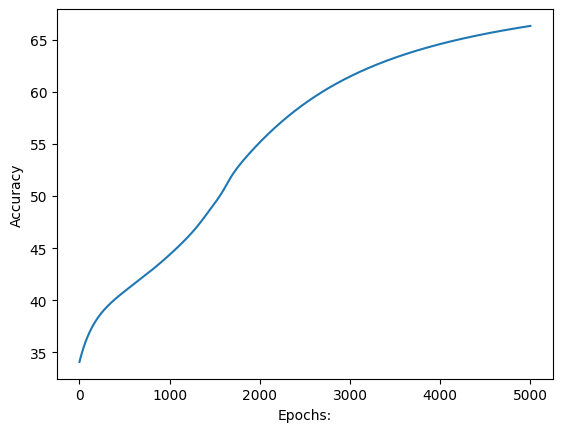

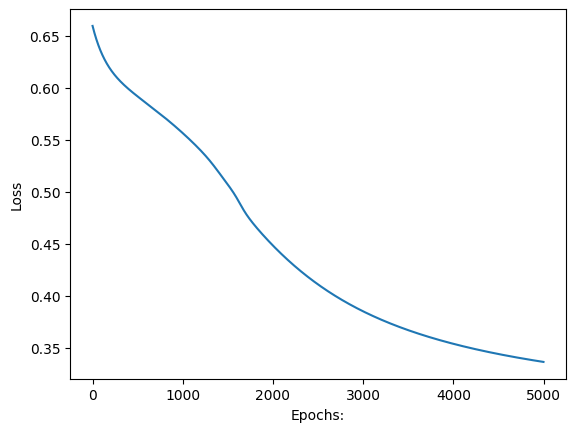

In [8]:
MSE = MeanSquareError()

net3 = NeuralNet([
    Linear(input_size=12, output_size=4),
    Activation(tanh, tanh_prime),
    Linear(input_size=4, output_size=6),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=6, output_size=6),
    Activation(tanh, tanh_prime),
    Linear(input_size=6, output_size=4),
    Activation(sigmoid, sigmoid_prime),
    Linear(input_size=4, output_size=1),
    Activation(sigmoid, sigmoid_prime),

])

train(net3, inputs=dataset.values, targets=labels.values, loss=MSE)